## Imports

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from warnings import filterwarnings

import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from io import BytesIO

from dataclasses import dataclass
from typing import List, Tuple

filterwarnings('ignore')


## Prepare Data

### Load Data

In [2]:
# Dummy excel
gsheet = "https://docs.google.com/spreadsheets/d/1S6_jPmeOA-SL6jDyX53FsQ3NPyWfZD8gfQ8CnBs7lqM/export?format=xlsx"

df = pd.read_excel(gsheet, engine="openpyxl", sheet_name="Analysis")
df.head()

,Date,Expense,Purpose,Category
0,2024-09-01,1194,Curtains,Flat
1,2024-09-01,112,Auto,Transport
2,2024-09-01,206,Mc Donalds,Food
3,2024-09-01,118,Auto,Transport
4,2024-09-01,140,Swiggy,Food


In [3]:
df.info()
print("\n========================================================\n")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      87 non-null     datetime64[ns]
 1   Expense   87 non-null     int64         
 2   Purpose   87 non-null     object        
 3   Category  87 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ KB




,Date,Expense
count,87,87.000000
mean,2024-09-20 03:35:10.344827648,712.908046
min,2024-09-01 00:00:00,10.000000
25%,2024-09-06 00:00:00,75.500000
50%,2024-09-20 00:00:00,160.000000
75%,2024-09-29 00:00:00,344.500000
max,2024-10-18 00:00:00,17103.000000
std,NaN,2468.418944


In [4]:
datetime.now().strftime("%U")

'04'

In [5]:
@dataclass
class DateConfig:
    # year = datetime.now().year
    # month = datetime.now().strftime("%B")
    # day = datetime.now().strftime("%A")
    # m = datetime.now().month
    # w = datetime.now().strftime("%U")
    date = datetime.now().day
    year = datetime.now().year - 1
    month = 'September'
    day = datetime.now().strftime("%A")
    m = 9


@dataclass
class UserConfig:
    target_expense = 5500/30
    max_over_expense = 300

datecfg = DateConfig
usrcfg = UserConfig

#### Calendar Data

In [6]:
def add_dt_features(expense_df:pd.DataFrame, ignore_cat:List=[], year:int=datecfg.year) -> pd.DataFrame:
    # Generate a date range for the entire year
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)

    # Create a date range for all dates in the year
    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")

    # Create a DataFrame with dates and day names
    df_dt = pd.DataFrame(
        {
            "Date": all_dates,
            "M": list(map(int, list(all_dates.strftime("%m")))), # Month number
            "YW": list(map(int, list(all_dates.strftime("%U")))), # Week number by year
            "W": list(map(int, list(all_dates.strftime("%w")))), # Week number
            "D": list(map(int, list(all_dates.strftime("%d")))), # Date number
            "Month": all_dates.strftime("%B"), # Month name
            "Day": all_dates.strftime("%A"), # Day name
        }
    )

    # Set filter for purpose and category
    purpose = expense_df['Purpose'].unique()
    category = set(expense_df['Category']) - set(ignore_cat)

    # Merge datetime data and the expense data
    df_dt_with_exp = df_dt.merge(expense_df[(expense_df['Purpose'].isin(purpose)) & (expense_df['Category'].isin(category))], left_on="Date", right_on="Date", how="left")

    return df_dt_with_exp


In [7]:
def create_calendar(df_dt_with_exp:pd.DataFrame, m:int=datecfg.m) -> pd.DataFrame:
    if m is not 'all' and isinstance(m, int):
        curr_month_df_dt_with_exp = df_dt_with_exp[df_dt_with_exp['M'] == m]
    elif m is 'all':
        curr_month_df_dt_with_exp = df_dt_with_exp  # Include all months
    else:
        print("Error")
    # Day level expense (filtered) with datetime attributes
    df_calendar = curr_month_df_dt_with_exp.groupby(['Date', 'M', 'YW', 'W', 'D', 'Month', 'Day']).agg({'Expense': lambda x: x.sum() if not x.isnull().all() else float('nan')}).reset_index()

    return df_calendar



#### Format calendar for a Month

In [8]:

def format_calendar(df_calendar: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    calendar = df_calendar.pivot(columns="Day", index=["Month", "YW"], values="D")[day_order]
    calendar_exp = df_calendar.pivot(columns="Day", index=["Month", "YW"], values="Expense")[day_order]

    return calendar, calendar_exp

In [9]:
def create_expense_calendar_graph(calendar: pd.DataFrame, calendar_exp: pd.DataFrame, year:int, month:str, date:int, avg_cap:int=usrcfg.target_expense, max_cap:int=usrcfg.max_over_expense):
    fig, ax = plt.subplots(figsize=(6.75, 5))
    highlight = calendar_exp.isna() & ~calendar.isna()
    remaining = calendar > date
    ignore = calendar.isna()

    custom_cmap = sns.diverging_palette(120, 25, 100, as_cmap=True)
    norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=avg_cap, vmax=max_cap)

    custom_cmap_h = sns.color_palette(["red"])
    custom_cmap_r = sns.color_palette(["gray"])
    custom_cmap_i = sns.color_palette(["black"])
    # Create a heatmap
    sns.heatmap(calendar_exp, annot=calendar, cmap=custom_cmap, norm=norm, linewidths=5, cbar=False, ax=ax)
    sns.heatmap(highlight, annot=calendar, mask=highlight == 0, cmap=custom_cmap_h, cbar=False, linewidths=5, ax=ax)
    sns.heatmap(remaining, annot=calendar, mask=remaining == 0, cmap=custom_cmap_r, cbar=False, linewidths=5, ax=ax)
    sns.heatmap(ignore, mask=ignore == 0, cmap=custom_cmap_i, cbar=False, linewidths=5, linecolor='black', ax=ax)

    for i in range(calendar_exp.shape[0]):
        for j in range(calendar_exp.shape[1]):
            if not ignore.iloc[i, j]:
                # First annotation in the top-left corner of the cell
                ax.text(j + 0.5, i + 0.75, f'\u20B9 {calendar_exp.fillna('---').iloc[i, j]}', color="black", ha="center", va="center", fontsize=6)

    ax.set_yticks([])
    ax.tick_params(axis='x', which='both', length=0, labelsize=8, labelcolor='white')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.xaxis.set_ticks_position('top')
    ax.set_title(f"{month} {year}", pad=30, color='white')
    ax.set_facecolor("black")
    fig.set_facecolor("black")

    return fig



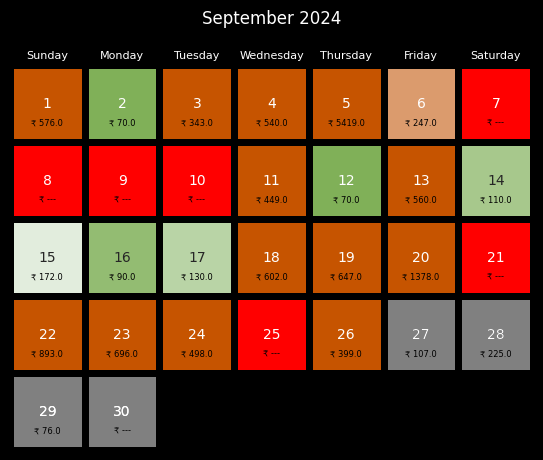

In [10]:
df_dt = add_dt_features(df, ['Flat'])
df_calendar = create_calendar(df_dt)
calendar, calendar_expense = format_calendar(df_calendar)
fig = create_expense_calendar_graph(calendar, calendar_expense, datecfg.year, datecfg.month, datecfg.date, usrcfg.target_expense, usrcfg.max_over_expense)


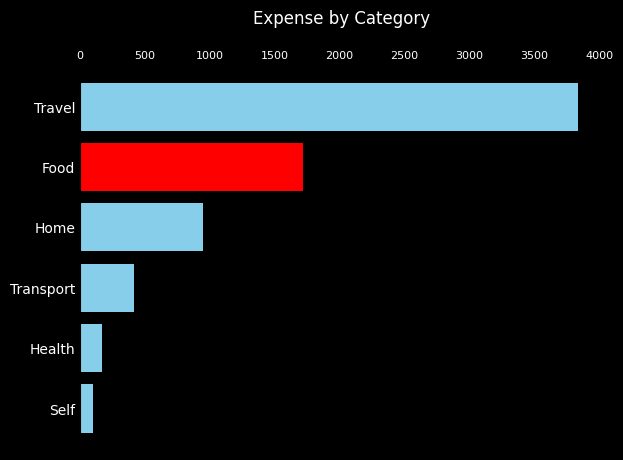

In [11]:
fig, ax = plt.subplots(figsize=(6.75, 5))
curr_week_cat_expense = df_dt[df_dt['YW']==35].groupby('Category')['Expense'].sum().reset_index().sort_values(by='Expense', ascending=True).reset_index(drop=True)

highlight_category = 'Food'
colors = ['red' if category == highlight_category and
          curr_week_cat_expense[curr_week_cat_expense['Category']==highlight_category]['Expense'].item() > 1100
          else 'green' if category == highlight_category and
          curr_week_cat_expense[curr_week_cat_expense['Category']==highlight_category]['Expense'].item() <= 1100
          else 'skyblue' for category in curr_week_cat_expense['Category']]

# Plot the bar chart
plt.barh(curr_week_cat_expense['Category'], curr_week_cat_expense['Expense'], color=colors)
ax.tick_params(axis='x', which='both', length=0, labelsize=8, labelcolor='white', direction='inout')
ax.tick_params(axis='y', which='both', length=0, labelsize=10, labelcolor='white')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks_position('top')
ax.set_title("Expense by Category", pad=30, color='white')
ax.set_facecolor("black")
fig.set_facecolor("black")

In [12]:
df_dt_1 = add_dt_features(df, ['Flat', 'Travel'])
curr_week_day_cat_expense = df_dt_1[df_dt_1['YW']==38].groupby(['Day', 'W', 'Category'])['Expense'].sum().reset_index().sort_values(by='W').reset_index(drop=True)
prev_week_day_cat_expense = df_dt_1[df_dt_1['YW']==37].groupby(['Day', 'W', 'Category'])['Expense'].sum().reset_index().sort_values(by='W').reset_index(drop=True)

curr_week_day_expense = curr_week_day_cat_expense.groupby(['Day', 'W'])['Expense'].sum().reset_index().sort_values(by='W').reset_index(drop=True)
prev_week_day_expense = prev_week_day_cat_expense.groupby(['Day', 'W'])['Expense'].sum().reset_index().sort_values(by='W').reset_index(drop=True)
prev_week_day_expense = prev_week_day_expense[prev_week_day_expense['Day'].isin(curr_week_day_expense['Day'].unique())]

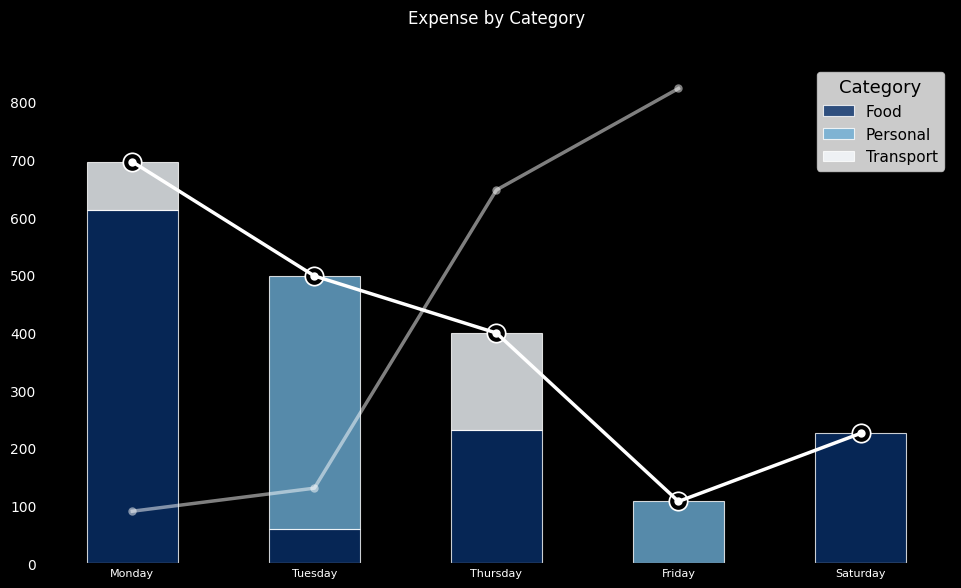

In [13]:
pivot_df = curr_week_day_cat_expense.pivot_table(index=["Day", "W"], columns="Category", values="Expense", aggfunc="sum", fill_value=0).reset_index().sort_values(by='W').drop(columns=["W"]).set_index("Day")

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind="bar", stacked=True, ax=ax, cmap="Blues_r", edgecolor="white", linewidth=0.8, alpha=0.8)
ax.plot(curr_week_day_expense['Day'], curr_week_day_expense['Expense'], color="white", linewidth=2.5)
ax.scatter(curr_week_day_expense['Day'], curr_week_day_expense['Expense'], color="white", linewidth=8.5)
ax.scatter(curr_week_day_expense['Day'], curr_week_day_expense['Expense'], color="black", linewidth=6)
ax.scatter(curr_week_day_expense['Day'], curr_week_day_expense['Expense'], color="white", linewidth=0.01)
ax.plot(prev_week_day_expense['Day'], prev_week_day_expense['Expense'], color="white", linewidth=2.5, alpha=0.5)
ax.scatter(prev_week_day_expense['Day'], prev_week_day_expense['Expense'], color="white", linewidth=0.01, alpha=0.5)



# Customizing the plot
ax.set_title("Weekly Expense Breakdown by Category", fontsize=16)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Total Expense ($)", fontsize=12)
ax.legend(title="Category", title_fontsize="13", fontsize="11")
plt.xticks(rotation=0, ha="center")
plt.tight_layout()
ax.tick_params(axis='x', which='both', length=0, labelsize=8, labelcolor='white', direction='inout')
ax.tick_params(axis='y', which='both', length=0, labelsize=10, labelcolor='white')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Expense by Category", pad=30, color='white')
ax.set_facecolor("black")
fig.set_facecolor("black")
plt.show()

In [14]:
calendar
nan_row = pd.DataFrame([[np.nan] * len(calendar.columns)], columns=calendar.columns, index=calendar.index).reset_index()
nan_row['YW'] = '-'
nan_row.groupby(['Month', 'YW']).max()
calendar_with_nan = pd.concat([calendar, nan_row], ignore_index=True)

In [15]:
df_calendar_complete = create_calendar(df_dt, 'all')

calendar_all, calendar_expense_all = [], []
for m in range(1, 13):
    calendar, calendar_expense = format_calendar(df_calendar_complete[df_calendar_complete['M']==m])
    calendar_all.append(calendar)
    nan_row = pd.DataFrame([[np.nan] * len(calendar.columns)], columns=calendar.columns, index=calendar.index).reset_index()
    nan_row['YW'] = '-'
    nan_row = nan_row.groupby(['Month', 'YW']).max()
    calendar_all.append(nan_row)

    calendar_expense_all.append(calendar_expense)
    nan_row_exp = pd.DataFrame([[np.nan] * len(calendar_expense.columns)], columns=calendar_expense.columns, index=calendar_expense.index).reset_index()
    nan_row_exp['YW'] = '-'
    nan_row_exp = nan_row.groupby(['Month', 'YW']).max()
    calendar_expense_all.append(nan_row_exp)

calendar_all_df, calendar_expense_all_df = pd.concat(calendar_all, axis=0), pd.concat(calendar_expense_all, axis=0)

In [16]:
y_tick_df = calendar_all_df.reset_index()
y_tick_df[y_tick_df.reset_index()["Month"] == 'November'].index[0].item()

62

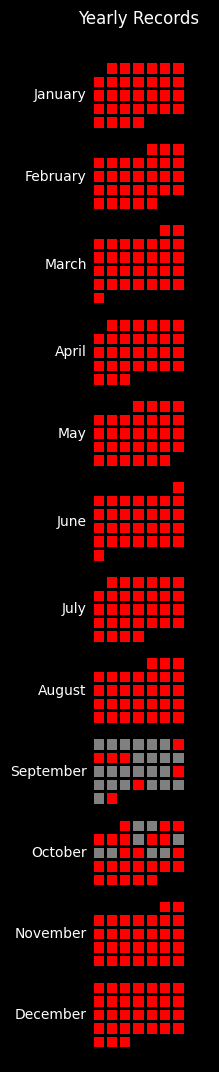

In [17]:
fig, ax = plt.subplots(figsize=(1.2, 13))
highlight = calendar_expense_all_df.isna() & ~calendar_all_df.isna()
ignore = calendar_all_df.isna()

custom_cmap_r = sns.color_palette(["gray"])
custom_cmap_h = sns.color_palette(["red"])
custom_cmap_i = sns.color_palette(["black"])
# Create a heatmap
sns.heatmap(calendar_expense_all_df, cmap=custom_cmap_r, linewidths=1, cbar=False, ax=ax)
sns.heatmap(highlight, mask=highlight == 0, cmap=custom_cmap_h, cbar=False, linewidths=1, ax=ax)
sns.heatmap(ignore, mask=ignore == 0, cmap=custom_cmap_i, cbar=False, linewidths=1, linecolor='black', ax=ax)

y_tick_df = calendar_expense_all_df.reset_index()
unique_months = y_tick_df['Month'].unique()

y_tick_pos = [
    (y_tick_df[y_tick_df.reset_index()["Month"] == month].index[0].item() + y_tick_df.reset_index()[y_tick_df["Month"] == month].index[-1].item()) / 2
    for month in unique_months
]

plt.yticks(y_tick_pos, unique_months)
ax.tick_params(axis='y', which='both', length=0, labelsize=10, labelcolor='white')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks_position('top')
ax.set_title(f"Yearly Records", pad=10, color='white')
ax.set_facecolor("black")
fig.set_facecolor("black")

---------------------

In [18]:
# def save_fig(fig):
#     buf = BytesIO()
#     fig.savefig(buf, format='png')
#     buf.seek(0)
#     plt.close()
#     return buf

In [19]:
# df_calendar = create_calendar(df)
# calendar, calendar_expense = format_calendar(df_calendar)
# fig = create_expense_calendar_graph(calendar, calendar_expense, datecfg.year, datecfg.month, usrcfg.target_expense, usrcfg.max_over_expense)
